In [1]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class TimeSeriesData():
    def __init__(self,num_points,xmin,xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax - xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size, steps,return_batch_ts=False):
        #Grab random staring point for each batch
        rand_start = np.random.rand(batch_size,1)
        #convert to be in time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps * self.resolution))
        
        #Create batch time series on the x axis
        batch_ts = ts_start + np.arange(0.0,steps + 1)* self.resolution
        
        #Create the Y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)
        # Formating for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1),y_batch[:,1:].reshape(-1,steps,1) , batch_ts
        else: 
            return y_batch[:,:-1].reshape(-1,steps,1),y_batch[:,1:].reshape(-1,steps,1)
    
    

In [3]:
ts_data = TimeSeriesData(250, 0,10)

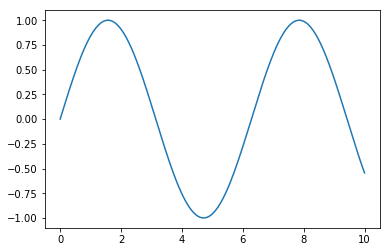

In [4]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [5]:
num_time_steps = 30

In [6]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

In [7]:
ts

array([[6.20449354, 6.24449354, 6.28449354, 6.32449354, 6.36449354,
        6.40449354, 6.44449354, 6.48449354, 6.52449354, 6.56449354,
        6.60449354, 6.64449354, 6.68449354, 6.72449354, 6.76449354,
        6.80449354, 6.84449354, 6.88449354, 6.92449354, 6.96449354,
        7.00449354, 7.04449354, 7.08449354, 7.12449354, 7.16449354,
        7.20449354, 7.24449354, 7.28449354, 7.32449354, 7.36449354,
        7.40449354]])

In [8]:
ts.shape

(1, 31)

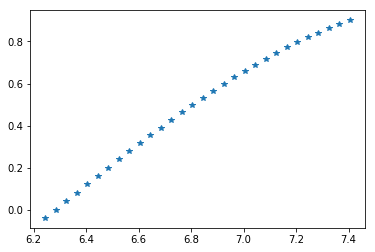

In [9]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

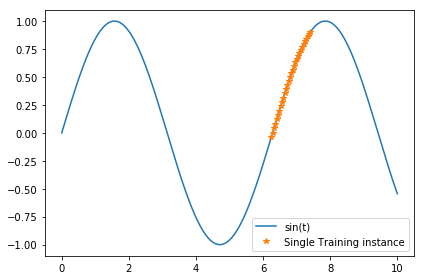

In [10]:
plt.plot(ts_data.x_data,ts_data.y_true,label='sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Training instance')
plt.legend()
plt.tight_layout()

In [11]:
#Training data 
train_inst = np.linspace(5,5+ts_data.resolution*(num_time_steps+1),num_time_steps+1)

In [12]:
train_inst

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

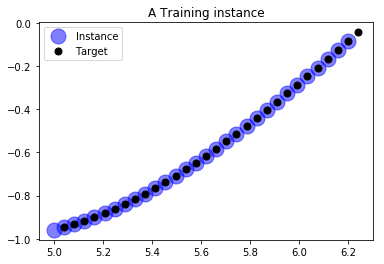

In [13]:
plt.title('A Training instance')
plt.plot(train_inst[:-1],ts_data.ret_true(train_inst[:-1]),'bo',markersize=15,alpha=0.5,label='Instance')
plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]),'ko',markersize=7,label='Target')
plt.legend()

In [14]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_rate = 0.001
num_train_iterations = 2000
batch_size = 1

In [15]:
#placeholders

In [16]:
X = tf.placeholder(tf.float32, [None,num_time_steps,num_inputs])
y = tf.placeholder(tf.float32, [None,num_time_steps,num_outputs])

In [17]:
# RNN cell layer

In [18]:
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.GRUCell(num_units=num_neurons,activation=tf.nn.relu),
                                            output_size=num_outputs)

In [19]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [20]:
#MSE
loss = tf.reduce_mean(tf.square(outputs-y))

In [21]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [22]:
train = optimizer.minimize(loss)

In [23]:
init = tf.global_variables_initializer()

In [24]:
saver =tf.train.Saver()

In [25]:

with tf.Session() as sess: 
    sess.run(init)
    for iteration in range (num_train_iterations):
        X_batch, y_batch = ts_data.next_batch(batch_size,num_time_steps)
        sess.run(train,feed_dict={X:X_batch,y:y_batch})
        if iteration % 100 ==0:
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration,"\tMSE",mse)
    saver.save(sess,'./rnn_time_series_model_codealong_andres_1')

0 	MSE 0.2366914
100 	MSE 0.038599115
200 	MSE 0.00596459
300 	MSE 0.033645194
400 	MSE 0.012527869
500 	MSE 0.0021685285
600 	MSE 0.004193027
700 	MSE 0.011613174
800 	MSE 0.0034757676
900 	MSE 0.0006352035
1000 	MSE 0.00108045
1100 	MSE 0.00070552557
1200 	MSE 7.374252e-05
1300 	MSE 0.00010446512
1400 	MSE 3.8439382e-05
1500 	MSE 6.0242877e-05
1600 	MSE 7.6032234e-06
1700 	MSE 6.569347e-05
1800 	MSE 6.188496e-05
1900 	MSE 1.0722671e-05


In [26]:
with tf.Session() as sess:
    saver.restore(sess,'./rnn_time_series_model_codealong_andres_1')
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
    y_pred = sess.run(outputs,feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong_andres_1


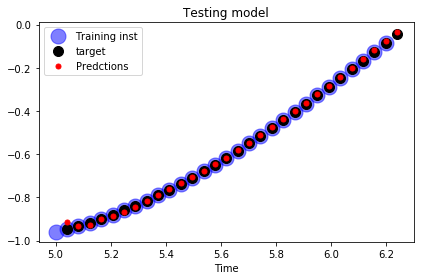

In [27]:
plt.title("Testing model")
## Training instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]),'bo', markersize=15,alpha=0.5,label='Training inst')
## Target Predict (Correct test values np.sin(train))
plt.plot(train_inst[1:],np.sin(train_inst[1:]), 'ko',markersize=10,label ='target')

#Models prediction
plt.plot(train_inst[1:],y_pred[0,:,0],'r.', markersize=10,label='Predctions')

plt.xlabel('Time')
plt.legend()
plt.tight_layout()

In [28]:
# Generating New Sequence
with tf.Session() as sess:
    saver.restore(sess,'./rnn_time_series_model_codealong_andres_1')
    #Seed zeros
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        y_pred = sess.run(outputs,feed_dict={X:X_batch})
        zero_seq_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong_andres_1


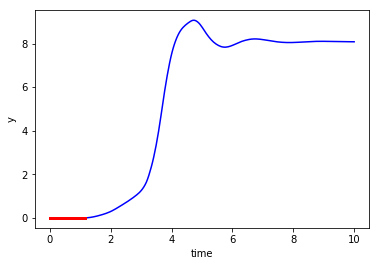

In [29]:
plt.plot(ts_data.x_data,zero_seq_seed,'b-')
plt.plot(ts_data.x_data[:num_time_steps],zero_seq_seed[:num_time_steps], 'r',linewidth=3)
plt.xlabel('time')
plt.ylabel('y')

In [30]:
with tf.Session() as sess:
    saver.restore(sess,'./rnn_time_series_model_codealong_andres_1')
    #Seed 
    training_instance = [0.0 for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1,num_time_steps,1)
        y_pred = sess.run(outputs,feed_dict={X:X_batch})
        training_instance.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong_andres_1


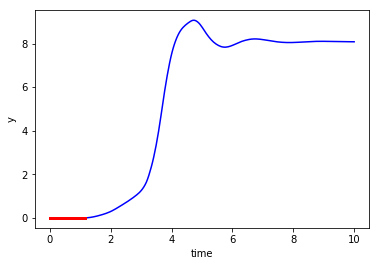

In [31]:
plt.plot(ts_data.x_data,training_instance,'b-')
plt.plot(ts_data.x_data[:num_time_steps],training_instance[:num_time_steps], 'r',linewidth=3)
plt.xlabel('time')
plt.ylabel('y')